In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras.backend as K

Using TensorFlow backend.


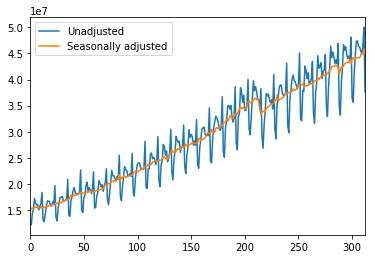

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv', 
                 skipfooter=9, skiprows=6, engine='python')
df.plot()

We will feed only one input at a time. We do it both with deep network and with LSTM.

============== Deep model - 1 input =====================

In [3]:
u = df['Unadjusted'].values
x = u[:-1]
y=u[1:]
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
xtr, xts = np.split(x, [250])
ytr, yts = np.split(y, [250])
sc = MinMaxScaler()
xsctr = sc.fit_transform(xtr)
xscts = sc.transform(xts)
ysctr = sc.transform(ytr)
yscts = sc.transform(yts)

C:\Users\liviu\Anaconda3\envs\ztdlg\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [4]:
model = Sequential()
model.add(Dense(12, activation='relu', input_shape=(1,)))
model.add(Dense(1, input_shape=(1,)))
model.compile('adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


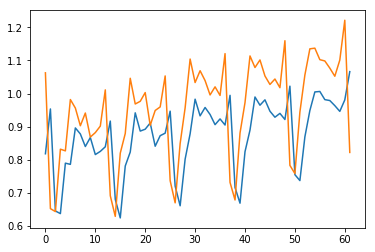

In [5]:
model.fit(xsctr, ysctr, epochs=10, batch_size=1, verbose=0)
y_pred = model.predict(xscts)
plt.plot(y_pred)
plt.plot(yscts)

======================= LSTM approach 1 - same as before, it mirrors the input ======================

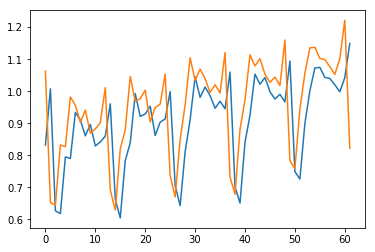

In [6]:
K.clear_session()
model = Sequential()
model.add(LSTM(12, input_shape=(1,1)))
model.add(Dense(1))
model.compile('adam', loss='mean_squared_error')
xsctrr = xsctr[:, None]
xsctsr = xscts[:, None]
model.fit(xsctrr, ysctr, epochs=10, batch_size=1, verbose=0)
y_pred = model.predict(xsctsr)
plt.plot(y_pred)
plt.plot(yscts)

Until now we only fed on previous input. We notice that the model does not predict the future values, it just mirrors the input, which is why the 2 graphs are identical, but shifted. Time to change the apporoach and feed in the last 12 values

======================= Approach 2 - consider last 12 values ==============================================

In [7]:
train_sc_df = pd.DataFrame(xsctr, columns=['Scaled'])
test_sc_df = pd.DataFrame(xscts, columns=['Scaled'])
train_sc_df.head()

,Scaled
0,0.014020
1,0.000000
2,0.070426
3,0.095318
4,0.163628


In [9]:
#shift so we have add 12 columns with the previous 12 values
for i in range(1, 13):
    train_sc_df['scaled_{}'.format(i)] = train_sc_df['Scaled'].shift(i)
    test_sc_df['scaled_{}'.format(i)] = test_sc_df['Scaled'].shift(i)

# drop original column
train_sc_df = train_sc_df.drop(['Scaled'], axis=1)
test_sc_df = test_sc_df.drop(['Scaled'], axis=1)

# remove NAN
train_data = train_sc_df[12:]
test_data = test_sc_df[12:]
y_tr = ysctr[12:]
y_ts = yscts[12:]

# switch to numpy
x_tr = train_data.values
x_ts = test_data.values

# reshape so we have data suited for LSTM
x_tr_l = x_tr.reshape((x_tr.shape[0], 1, 12))
x_ts_l = x_ts.reshape((x_ts.shape[0], 1, 12))

========================== LSTM approach ===========================

In [25]:
model1 = Sequential()
model1.add(LSTM(6, input_shape=(1,12)))
model1.add(Dense(1))
model1.compile('adam', 'mean_squared_error')
model1.fit(x_tr_l, y_tr, epochs=10, batch_size=1)
y_pred = model1.predict(x_ts_l)
plt.plot(y_pred)
plt.plot(y_ts)

========================== Deep approach ===========================

Epoch 1/20
238/238 [==============================] - 0s - loss: 0.1578     
Epoch 2/20
238/238 [==============================] - 0s - loss: 0.0045     
Epoch 3/20
238/238 [==============================] - 0s - loss: 0.0033     
Epoch 4/20
238/238 [==============================] - 0s - loss: 0.0027     
Epoch 5/20
238/238 [==============================] - 0s - loss: 0.0025     
Epoch 6/20
238/238 [==============================] - 0s - loss: 0.0021     
Epoch 7/20
238/238 [==============================] - 0s - loss: 0.0021     
Epoch 8/20
238/238 [==============================] - 0s - loss: 0.0021     
Epoch 9/20
238/238 [==============================] - 0s - loss: 0.0018     
Epoch 10/20
238/238 [==============================] - 0s - loss: 0.0020     
Epoch 11/20
238/238 [==============================] - 0s - loss: 0.0018     
Epoch 12/20
238/238 [==============================] - 0s - loss: 0.0018     
Epoch 13/20
238/238 [==============================] - 0s - loss: 0.0016 

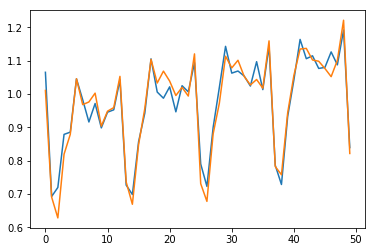

In [43]:
model2 = Sequential()
model2.add(Dense(12, input_shape=(12,), activation='relu'))
model2.add(Dense(1, activation='relu'))
model2.compile('adam', "mean_squared_error")
model2.fit(x_tr, y_tr, epochs=20, batch_size=1)
y_pred = model2.predict(x_ts)
plt.plot(y_pred)
plt.plot(y_ts)

It is pretty clear that this approach works better for predicting the patterns. The 2 graphs are aligned, which means that the model was able to predict the future values.